# Forecasting with Time Series 

Link to this notebook: https://github.com/escience-academy/2019-10-10-NSO-Symposium/blob/master/notebooks/3-Analysis-daily.ipynb

In [1]:
from pathlib import Path
import iris
import pandas as pd
import numpy as np
data_path = Path("data")

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import iris.analysis
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# Dataset

* Daily reanalysis data Era interim - now, 2-meter temperature:  http://climexp.knmi.nl/ERA-interim/erai_t2m_daily.nc


## Calculate global mean temperature

In [3]:
# cube = iris.load_cube(str(data_path / "erai_t2m_daily.nc"))
# cube.coord('latitude').guess_bounds()
# cube.coord('longitude').guess_bounds()
# tcoord = cube.coord('time')
# tcoord.units = cf_units.Unit(tcoord.units.origin, calendar='gregorian')
# cube.coord('time').convert_units('seconds since 1979-01-15')
# grid_areas = iris.analysis.cartography.area_weights(cube);
# temp_mean = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
# iris.save(temp_mean, './data/temp_mean_daily.nc')
# print(temp_mean.shape)

## Download previously saved global mean temperature data (File size 244K)

In [4]:
import urllib.request
url = 'https://raw.githubusercontent.com/escience-academy/2019-10-10-NSO-Symposium/master/notebooks/data/temp_mean_daily.nc'
urllib.request.urlretrieve(url, './nso_temp_mean_daily.nc')

('./nso_temp_mean_daily.nc', <http.client.HTTPMessage at 0x7ff5f13ce510>)

In [5]:
temp_mean = iris.load_cube('./nso_temp_mean_daily.nc')

## Use previously saved global mean temperature data

## Visualize the data

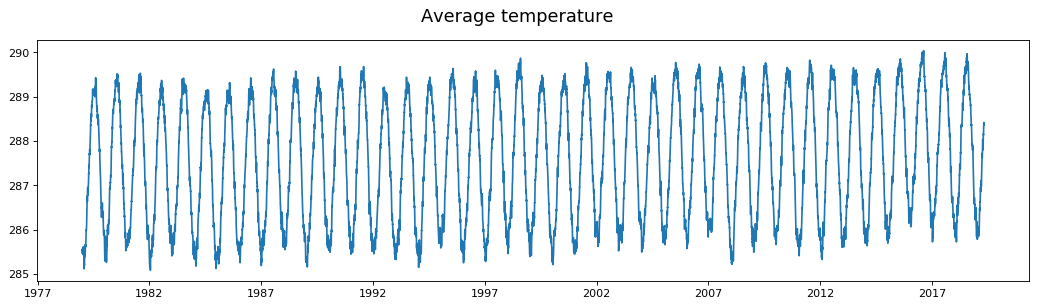

In [6]:
fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('Average temperature', fontsize=16)

iplt.plot(temp_mean)
plt.show()

# Machine Learning

## https://facebook.github.io/prophet

### - Prophet expects data as a pandas dataframe with 2 columns:
    - a ds (datestamp)
    - y (value we want to forecast)
    
### - Steps:
  1. Convert netCDF data into dataframe
  2. Create an instance of the Prophet class and then fit our dataframe to it.
    - Keep part of the data for forecasting
  3. Create a dataframe with the dates for which we want a prediction to be made with make_future_dataframe()
    - specify the number of days to forecast using the periods parameter
  4. Call predict to make a prediction and store it in the forecast dataframe
  5. Check the predictions as well as the lower and upper boundaries of the uncertainty interval.

In [7]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

## Step-1 Format the data

In [8]:
# Create a new DataFrame with which we will create/train our Prophet model 
df = pd.DataFrame()
mean_time_coord = temp_mean.coord('time')
df['ds'] = [mean_time_coord.units.num2date(mean_time_coord.points[date_index]).strftime('%Y-%m-%d') for date_index in range(mean_time_coord.points.size)]
df['y'] = temp_mean.data
df.shape

(14730, 2)

## Step-2 Create the model


In [9]:
forecast_duration = 730 # we will forecast last 730 days

In [10]:
# model = Prophet(seasonality_mode='multiplicative', mcmc_samples=1000).fit(df[:-forecast_duration])
# model = Prophet(mcmc_samples=1000).fit(df[:-forecast_duration])
model = Prophet().fit(df[:-forecast_duration])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


By setting the argument mcmc_samples to a non-zero value, the fitting process will return not just the optimal value for each of the parameters, but also full a MCMC approximation of the posterior. **This will make the fitting process take longer.**

## Step-3 Forecasting

In [11]:
future = model.make_future_dataframe(periods=forecast_duration)

## Step-4 Make the prediction

In [12]:
forecast = model.predict(future)

## Save the model and forcast data (for later use)

In [13]:
import pickle
pkl_path = "./model_500.pkl"
with open(pkl_path, "wb") as f:
    pickle.dump(model, f)
forecast.to_pickle("./forecast_500.pkl")

with open(pkl_path, 'rb') as f:
    model = pickle.load(f)

forecast = pd.read_pickle("./forecast_500.pkl")

## Step-5 Check the prediction
## Visualize the forecast

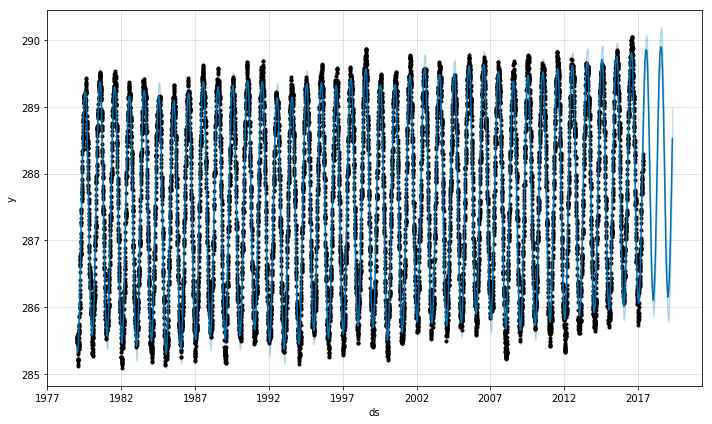

In [14]:
fig1 = model.plot(forecast)

## Check the trends

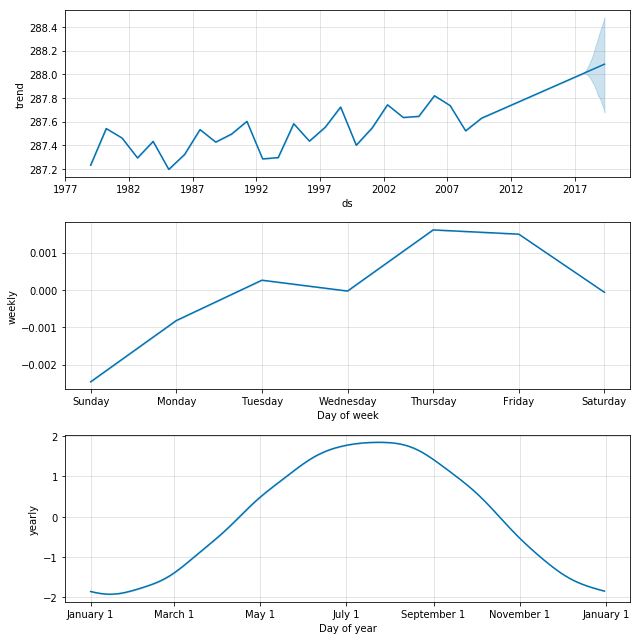

In [15]:
fig2 = model.plot_components(forecast)

## Compare the actual data and the forcasted data

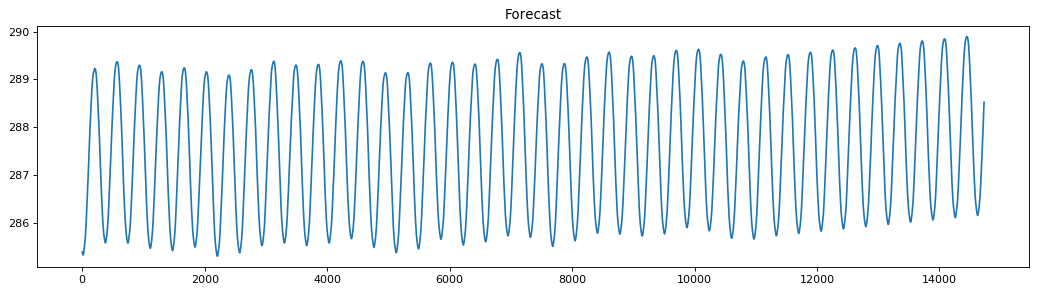

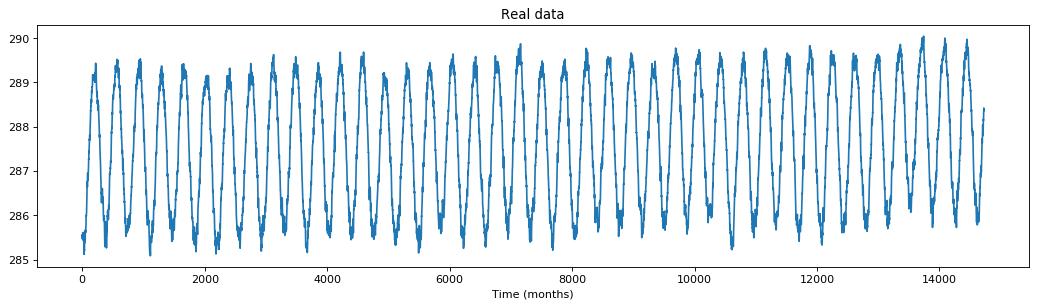

In [16]:
fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(forecast['yhat'])
plt.title('Forecast')
plt.grid(False)

fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(df['y'])
plt.title('Real data')
plt.xlabel('Time (months)')
plt.grid(False)
plt.show()

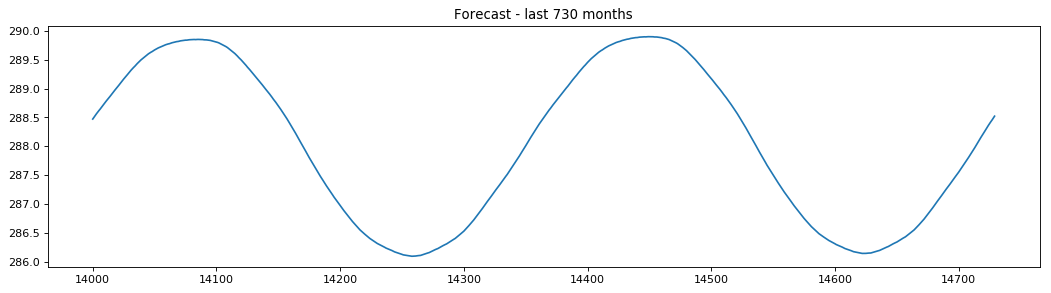

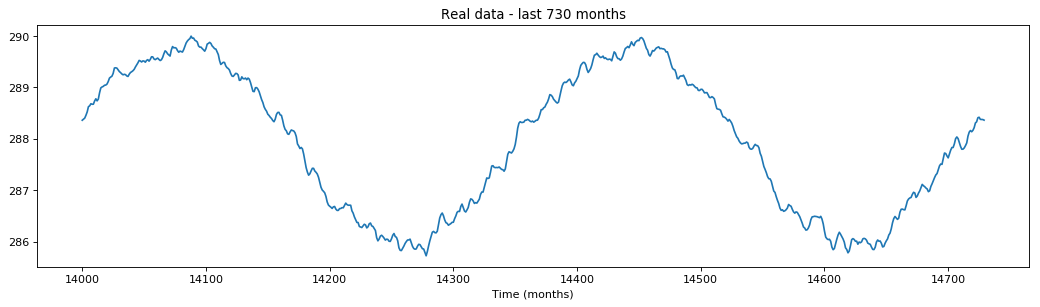

In [17]:
fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(forecast['yhat'][-forecast_duration:])
plt.title('Forecast - last 730 months')
plt.grid(False)

fig=plt.figure(figsize=(16, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(df['y'][-forecast_duration:])
plt.title('Real data - last 730 months')
plt.xlabel('Time (months)')
plt.grid(False)
plt.show()

In [18]:
forecast.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1979-01-01  287.231547  285.194628  285.595489   287.231547   287.231547   
1 1979-01-02  287.232239  285.171595  285.586351   287.232239   287.232239   
2 1979-01-03  287.232931  285.174488  285.562107   287.232931   287.232931   
3 1979-01-04  287.233622  285.165198  285.564591   287.233622   287.233622   
4 1979-01-05  287.234314  285.163288  285.555621   287.234314   287.234314   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0       -1.849052             -1.849052             -1.849052 -0.000820   
1       -1.856371             -1.856371             -1.856371  0.000263   
2       -1.864722             -1.864722             -1.864722 -0.000028   
3       -1.870764             -1.870764             -1.870764  0.001611   
4       -1.878136             -1.878136             -1.878136  0.001497   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -0.000820     -0.000820 -1.848232     -1.848232     -1.848232   
1      0.000263      0.000263 -1.856633     -1.856633     -1.856633   
2     -0.000028     -0.000028 -1.864694     -1.864694     -1.864694   
3      0.001611      0.001611 -1.872375     -1.872375     -1.872375   
4      0.001497      0.001497 -1.879634     -1.879634     -1.879634   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  285.382495  
1                         0.0  285.375868  
2                         0.0  285.368209  
3                         0.0  285.362859  
4                         0.0  285.356178

In [19]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [20]:
forecast_duration

730

In [21]:
cross_validation_results = cross_validation(model=model, initial=np.timedelta64(10000, 'D'), period=np.timedelta64(180, 'D'), horizon=np.timedelta64(forecast_duration, 'D'))
cross_validation_results.head()

INFO:fbprophet:Making 19 forecasts with cutoffs between 2006-06-17 00:00:00 and 2015-05-01 00:00:00


ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2006-06-18  289.416726  289.227969  289.600827  289.440694 2006-06-17
1 2006-06-19  289.432231  289.226114  289.625585  289.444876 2006-06-17
2 2006-06-20  289.446184  289.262847  289.630356  289.411375 2006-06-17
3 2006-06-21  289.458137  289.263757  289.651798  289.405208 2006-06-17
4 2006-06-22  289.471179  289.293388  289.657572  289.424197 2006-06-17

In [22]:
performance_metrics_results = performance_metrics(cross_validation_results)
performance_metrics_results.head()

horizon       mse      rmse       mae      mape  coverage
0 73 days  0.034627  0.186083  0.140948  0.000491  0.745494
1 74 days  0.035003  0.187090  0.141808  0.000494  0.742610
2 75 days  0.035299  0.187879  0.142321  0.000496  0.740447
3 76 days  0.035629  0.188755  0.143087  0.000498  0.739005
4 77 days  0.035880  0.189420  0.143687  0.000500  0.736842

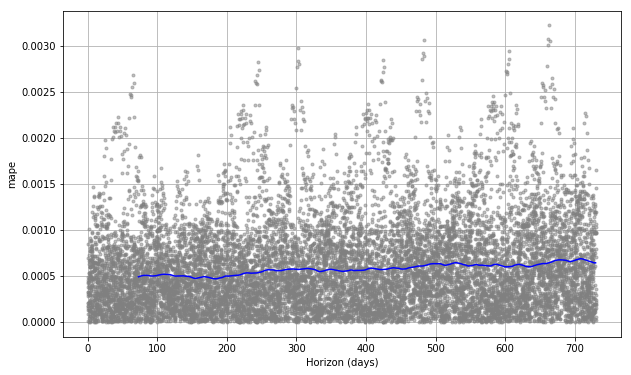

In [23]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cross_validation_results, metric='mape') # mape --> mean absolute percent error